# 1. Task 1

In this task, we decided to consider it to be a binary classification problem, i.e. predict if the given player is a dark skin person or a light skin one. We separated the range of skintone ([0, 1]) equally to get two classes.

## 1.1 Basic procedures
Import some library classes and data

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import GridSearchCV, GroupShuffleSplit, ShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.metrics import silhouette_score


data = pd.read_csv('CrowdstormingDataJuly1st.csv', quotechar='"')

## 1.2 First Model for Task 1
### 1.2.1 Data prepocessing
Here we describe the first assumption we give on data.
To produce the feature matrix, we did the following convertions:

1. use the mean of rater1 and rater2 as the target skintone
2. map club, league, position and group columns into integer numbers
3. get ages of players from the column birthday

**Note:** Here we map the playerShort to a categorical variable and get its codes for further use, because we don't want the same player appear in both train and test dataset. The classifier would otherwise match train and test data of the same player, in which case we would see super high accuracy around 99%, which however is not accurate at all. In that case, we are only searching the same person in test dataset rather than predicting. We also prove this below.

In [25]:
def get_numeric_features(data, features, new_feat=None):
    """
    Params:
        features(list): requested feature columns
        
    Return:
        x(list): feature matrix
        y(list): target variable list
        g(list): group code of each player
    """
    # get targe variable  
    data.dropna(subset=['rater1', 'rater2'], inplace=True)
    mean_rate = (data['rater1'] + data['rater2']) / 2
    data['skintone'] = mean_rate > 0.5
    data['skintone'] = data['skintone'].astype('int')
    # map categorical variables to codes
    data['club'] = data['club'].astype('category').cat.codes
    data['league'] = data['leagueCountry'].astype('category').cat.codes
    data['position'] = data['position'].astype('category').cat.codes
    data['group'] = data['playerShort'].astype('category').cat.codes
    # generate age feature
    data['age'] = 2016 - data['birthday'].str.rsplit('.', 1, True)[1].astype('int')
    
    # add new features
    if new_feat is not None:
        data = pd.concat([data, new_feat], axis=1)

    # choose desired features only
    x = data[features]
    y = data['skintone']
    g = data['group']

    return x, y, g

The following two functions are used to draw a chart showing train and test scores to see overfitting

In [46]:
def draw_cv(train, test, x, x_label):
    plt.plot(x, train, 'b-')
    plt.plot(x, test, 'r-')
    ax = plt.gca()
    top = max(np.max(train), np.max(test))
    bottom = min(np.min(train), np.min(test))
    margin = (top - bottom) * 0.1
    ax.set_ylim(bottom=bottom+margin, top=top+margin)
    plt.xlabel(x_label)
    plt.ylabel('error')
    plt.title('visualization')
    plt.show()


def get_train_test_score(res, params):
    res_pd = pd.DataFrame(res)
    temp = res_pd
    for k, v in params.items():
        temp = temp[temp[k] == v]
    train = temp[[col for col in temp.columns 
                  if 'train' in col and 'mean' not in col and 'std' not in col]]
    test = temp[[col for col in temp.columns 
                 if 'test' in col and 'mean' not in col and 'std' not in col and 'rank' not in col]]
    return train.mean(axis=1).tolist(), test.mean(axis=1).tolist()

### 1.2.2 Model Selection and Parameter Tuning
Here, we build a pipeline to do cross validation to find the best model and paramters. We can also see the train scores and test scores in the meantime.

We first set two paramters of `RandomForestClassifier`, n_estimators and max_features, to be `[i for i in range(1, 10)]` and `['auto', 'sqrt', 'log2']` respectively, and then run the grid search cross validation on the classifier with each pair of the two parameters.

In [27]:
# parameters of RandomForestClassifier to be tested
params={
    'rf__n_estimators': [i for i in range(1, 10)],
    'rf__max_features': ['sqrt', 'log2', None],
}

pipe = Pipeline([
         ('replace', Imputer(strategy='median')),  # replace NaN value with median valuep
         ('standardize', StandardScaler()),  # standardization 
         ('rf', RandomForestClassifier(n_jobs=-1))  # classification
     ])

# feature columns that we want to use
all_features = [
    'league', 'club', 'height', 'weight', 'age', 'position', 
    'games', 'victories', 'ties', 'defeats', 'goals', 
    'yellowCards', 'yellowReds', 'redCards', 
    'refNum', 'refCountry',
    'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'
]

x, y, groups = get_numeric_features(data, all_features)

**Note:** We first use `ShuffleSplit`, which is supposed to used on i.i.d samples, to show how super accuracy is acquired.

In [28]:
# use GridSearchCV to do the cross valiation to find best parameter set
gs_cv = GridSearchCV(pipe, params, n_jobs=-1,
                    cv=ShuffleSplit(n_splits=20, test_size=0.2, train_size=0.8))
gs_cv.fit(x, y, groups)

GridSearchCV(cv=ShuffleSplit(n_splits=20, random_state=None, test_size=0.2, train_size=0.8),
       error_score='raise',
       estimator=Pipeline(steps=[('replace', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='...mators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rf__n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'rf__max_features': ['sqrt', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

We could observe that the **best cv_score is 0.9993**, which is contradict to our intuition.

In [29]:
gs_cv.best_score_, gs_cv.best_params_

(0.99924172517552656, {'rf__max_features': None, 'rf__n_estimators': 7})

Then we noticed our samples **are not i.i.d samples**, and thus we choose to group the samples from the same players so as to eliminate such inaccuracy caused by matching the data of the same person.

In [5]:
# use GridSearchCV to do the cross valiation to find best parameter set
gs_cv = GridSearchCV(pipe, params, n_jobs=-1,verbose = 1,
                    cv=GroupShuffleSplit(n_splits=20, test_size=0.2, train_size=0.8))
gs_cv.fit(x, y, groups)

Fitting 20 folds for each of 27 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.3min finished


GridSearchCV(cv=GroupShuffleSplit(n_splits=20, random_state=None, test_size=0.2,
         train_size=0.8),
       error_score='raise',
       estimator=Pipeline(steps=[('replace', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_spl...ators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rf__n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'rf__max_features': ['sqrt', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

### 1.2.3 Result
Find the best score and the best parameter pair for the baseline.
This time, we could observe the best cv score to be 0.8324

In [6]:
gs_cv.best_score_, gs_cv.best_params_

(0.83307737157781125, {'rf__max_features': 'log2', 'rf__n_estimators': 8})

We use the group of train scores and test scores whose `max_features` is set to `'log2'` and `n_estimators` is set to a range of list to show we are overfitting the dataset. 

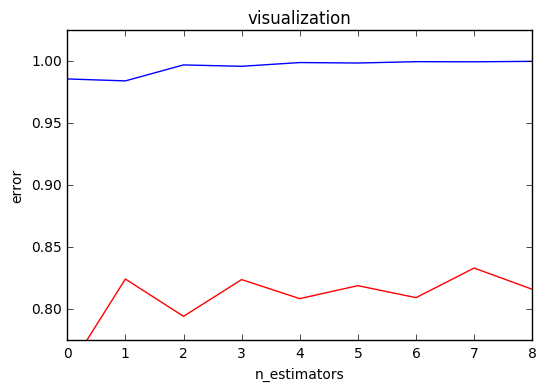

In [49]:
res = gs_cv.cv_results_
train, test = get_train_test_score(res, {'param_rf__max_features': 'log2'})
draw_cv(train, test, [i for i in range(9)], 'n_estimators')

After checking the feature importance of the best model, we found the most important features are `club`, `height`, `weight`. This is quite different from our second model, which we will show later.

In [8]:
gs_cv.best_estimator_.get_params()['rf'].feature_importances_

array([ 0.05514466,  0.16076537,  0.16073984,  0.16375406,  0.14731064,
        0.12033121,  0.01375923,  0.01257253,  0.00879998,  0.01033054,
        0.01021429,  0.00748712,  0.00095123,  0.00095453,  0.0252033 ,
        0.01421923,  0.02643653,  0.00938902,  0.01076509,  0.01921291,
        0.00997936,  0.01167933])

## 1.3 Second Model for task1
Since method above consists many redundant information, which makes the model training process very time-consuming. We decide to group the data by playerShort.

### 1.3.1 Data prepocessing
To apply groupby, we should at first determine the aggregate function for each column(feature).
According to characteristics of different features, we follow the aggregation rules below (the first three rules remain same as model):
1. we use the mean of rater1 and rater2 as the target skintone
2. map club, league, position and group columns into integer numbers
3. get ages of players from the column birthday
4. For features['skintone','club', 'height', 'weight', 'position', 'age'], we keep the original value of each player.
5. For features['games','victories', 'ties', 'defeats', 'goals', 'yellowCards','yellowReds', 'redCards'], we sum the value of each player.
6. For features ['mean_IAT','mean_Exp'], we calcualte the weighted means (with games) of each player, thus transform them into ['w_IAT','W_ExP']. ('w' denotes weighted)
7. For features ['refNum', 'refCountry','nIAT', 'seIAT', 'nExp', 'seExp'], it doesn't make sense to aggregate them, so we discard these featues.  
After applying these rules to groupby and aggregate function, we obatin a feature matrix with size of 1585*17.

In [2]:
def get_x_y(data,new_feat=None):
    """
    Params:
        
    Return:
        x(list): feature matrix
        y(list): target variable list
    """
    # get targe variable  
    data.dropna(subset=['rater1', 'rater2'], inplace=True)
    mean_rate = (data['rater1'] + data['rater2']) / 2
    data['skintone'] = mean_rate > 0.5
    data['skintone'] = data['skintone'].astype('int')
    # map categorical variables to codes
    data['club'] = data['club'].astype('category').cat.codes
    data['league'] = data['leagueCountry'].astype('category').cat.codes
    data['position'] = data['position'].astype('category').cat.codes
    # generate age feature
    data['age'] = 2016 - data['birthday'].str.rsplit('.', 1, True)[1].astype('int')
    data['w_IAT'] = data['games'] * data['meanIAT']
    data['w_EXP'] = data['games'] * data['meanExp']
    feature_ = ['skintone','club', 'height', 'weight', 'position', 'age',
                'league','playerShort','games','victories', 'ties', 
                'defeats', 'goals', 'yellowCards','yellowReds', 'redCards', 
                'w_IAT', 'w_EXP']
    x_group1 = data[feature_].ix[:,0:8].groupby(by='playerShort').agg(np.mean)
    x_group2 = data[feature_].ix[:,7:18].groupby(by='playerShort').agg(np.sum)
    x_group = pd.concat([x_group1,x_group2],axis = 1)
    x_group.w_IAT = x_group.w_IAT / x_group.games
    x_group.w_EXP = x_group.w_EXP / x_group.games
    y = x_group.skintone
    x = x_group.ix[:,1:17]
    # add new features
    if new_feat is not None:
        data = pd.concat([data, new_feat], axis=1)
    return x, y


### 1.3.2 Model Selection and Parameter Tuning
We still use pipeline to do model selection and parameter tuning. As a result of the reduction of data size due to groupby, we can test more random forest classifier parameters now.   
We let the parameter set as the combination of different n_estimators, max_features and max_depths. Parameter n_estimators range from 5 to 25, parameter max_features range in  `['auto', 'sqrt', 'log2']` ,and parameter max_depth range from 5 to 25.  
We then run the grid search cross validation on the classifier with each pair of the three parameters.

In [22]:
# parameters of RandomForestClassifier to be tested
params={
    'rf__n_estimators': [i for i in range(5, 26)],
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__max_depth': [i for i in range(5,26)]
}

pipe = Pipeline([
         ('replace', Imputer(strategy='median')),  # replace NaN value with median valuep
         ('rf', RandomForestClassifier(n_jobs=-1))  # classification
     ])

x_2, y_2 = get_x_y(data)

In [4]:
# use GridSearchCV to do the cross valiation to find best parameter set
gs_cv_2 = GridSearchCV(pipe, params, n_jobs=-1,
                    cv=ShuffleSplit(n_splits=20, test_size=0.2, train_size=0.8))
gs_cv_2.fit(x_2, y_2)

GridSearchCV(cv=ShuffleSplit(n_splits=20, random_state=None, test_size=0.2, train_size=0.8),
       error_score='raise',
       estimator=Pipeline(steps=[('replace', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_spl...ators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rf__max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 'rf__n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 'rf__max_features': ['sqrt', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

### 1.3.3 Result
We could observe that, this time, the **best cross validation score is 0.8497**, which improves a bit compared to the first model. **The best parameter set is  {'max_depth': 6, 'max_features': 'log2', 'n_estimators': 25}.**

In [5]:
gs_cv_2.best_score_, gs_cv_2.best_params_

(0.84842271293375393,
 {'rf__max_depth': 21, 'rf__max_features': 'log2', 'rf__n_estimators': 25})

We could also give the feature_importances. We find that **the most important features are 'weighted mean of IATscore' and 'weighted mean of Exp score', while the least important features are 'yellowReds' and 'redCards' **

In [6]:
f_importance_2 = gs_cv_2.best_estimator_.get_params()['rf'].feature_importances_
f_importance_2

array([ 0.06672991,  0.05214417,  0.05665237,  0.0411245 ,  0.04477985,
        0.0578409 ,  0.06585295,  0.07985616,  0.05489152,  0.06987497,
        0.07734497,  0.06031401,  0.02388019,  0.02271411,  0.12232772,
        0.10367171])

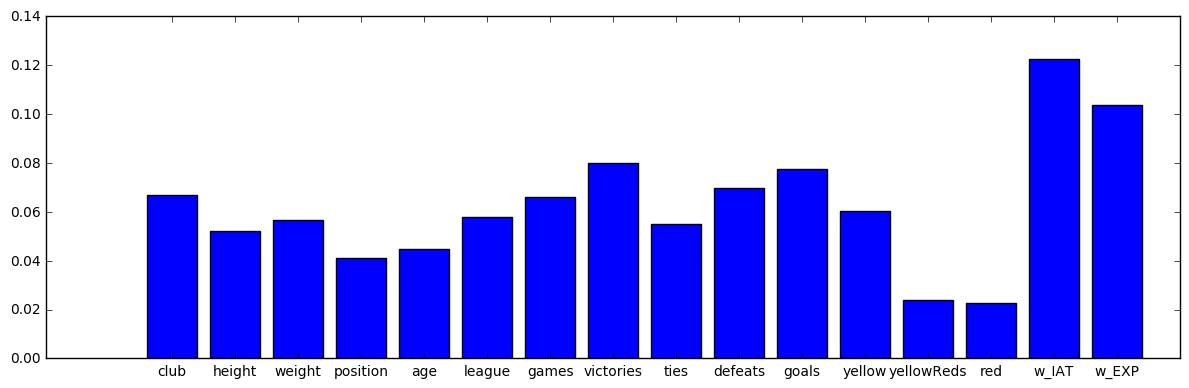

In [7]:
f_label = ['club', 'height', 'weight', 'position', 'age',
                'league','games','victories', 'ties', 
                'defeats', 'goals', 'yellow','yellowReds', 'red', 
                'w_IAT', 'w_EXP']

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12,4))

plt.bar(range(len(f_importance_2)), f_importance_2, align="center")
plt.xticks(range(len(f_importance_2)),f_label, color='black')

fig.tight_layout()
plt.show()

### 1.3.4 Comparisons between different classifier parameter sets.  (BONUS)
According to the result of gridsearchCV, we could compare different classifier parameter sets. We choose the best parameter set `{'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__n_estimators': 25}` and the worst parameter set `{'rf__max_depth': 22, 'rf__max_features': None, 'rf__n_estimators': 5}` to plot the learning curve with incresing the training data size smoothly

In [43]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(ax, estimator, title, X, y, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):    
    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    return ax

tx_2 = Imputer(strategy='median').fit_transform(x_2)

We can see from the learning curve that best model always achieved better results than worst model. Both cv results are increasing with the increase of training data size.

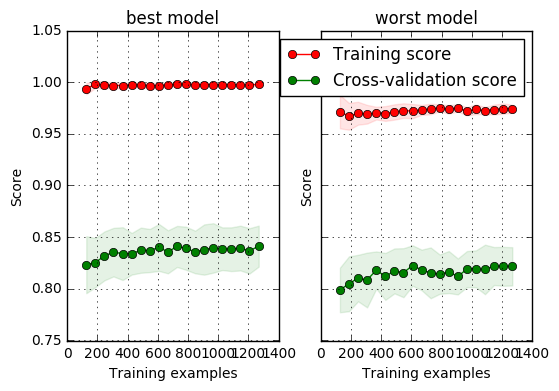

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
plot_learning_curve(ax1, RandomForestClassifier(n_jobs=-1, max_depth=21, max_features='log2', n_estimators=25), 'best model',
                    tx_2, np.array(y_2.values.tolist()),
                    cv=ShuffleSplit(n_splits=20, test_size=0.2, train_size=0.8),
                    n_jobs=-1, train_sizes=np.linspace(0.1, 1, 20))
plot_learning_curve(ax2, RandomForestClassifier(n_jobs=-1, max_depth=23, max_features='sqrt', n_estimators=5), 'worst model',
                    tx_2, np.array(y_2.values.tolist()),
                    cv=ShuffleSplit(n_splits=20, test_size=0.2, train_size=0.8),
                    n_jobs=-1, train_sizes=np.linspace(0.1, 1, 20))
plt.legend(loc="best")
plt.show()

If we fix the max_feature to be 'log2', then we could observe the cv_score of different max_depth and n_estimator parameter sets.

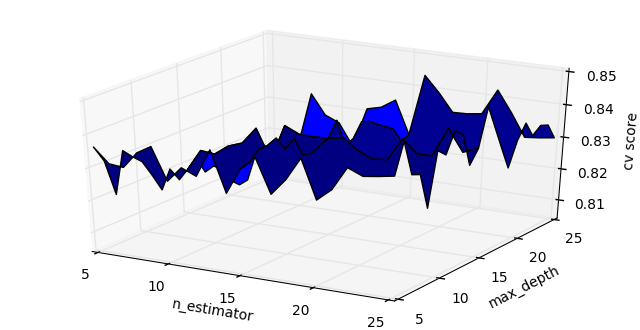

In [58]:
from mpl_toolkits.mplot3d import axes3d
mean_scores = np.array(gs_cv_2.cv_results_['mean_test_score'])
# Axes3D.plot_wireframe(X, Y, Z, *args, **kwargs)¶
# gs_cv_2.cv_results_['mean_test_score']

mean_scores = mean_scores.reshape((21,63))
log2_mean_scores = mean_scores[:, 21:42]

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection='3d')
# X, Y, Z = axes3d.get_test_data(0.05)
p_x, p_y = np.meshgrid(range(5,26), range(5,26))

# surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)
ax.plot_surface(p_x,p_y,log2_mean_scores) #, rstride=10, cstride=10)
# ax.plot_wireframe(range(5,26), range(5,26),log2_mean_scores) #, rstride=10, cstride=10)
ax.set_xlabel('n_estimator')
ax.set_ylabel('max_depth')
ax.set_zlabel('cv score')

plt.show()


### 1.3.5 Drop the least important feature
According to the feature_importance result of model above, we try to do give a different assumption on raw data. We drop the two lesat important features, namely['yellowReds','redCards']. And then run our pipeline again to observe the result.

In [45]:
# Drop feature
x_2_drop = pd.concat([x_2.ix[:,0:12],x_2.ix[:,14:16]],axis = 1)
gs_cv_2_drop = GridSearchCV(pipe, params, n_jobs=-1,
                    cv=ShuffleSplit(n_splits=20, test_size=0.2, train_size=0.8))
gs_cv_2_drop.fit(x_2_drop, y_2)

GridSearchCV(cv=ShuffleSplit(n_splits=20, random_state=None, test_size=0.2, train_size=0.8),
       error_score='raise',
       estimator=Pipeline(steps=[('replace', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_spl...ators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rf__n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 'rf__max_features': ['sqrt', 'log2', None], 'rf__max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

The best score after dropping least important feature **increases to 0.85078**. The best classifier parameter set is  **{'rf__max_depth': 25, 'rf__max_features': 'sqrt', 'rf__n_estimators': 17}.**  
Therefore, dropping some unimportant features, could help improve the classification performance in this case.

In [47]:
gs_cv_2_drop.best_score_, gs_cv_2_drop.best_params_

(0.850788643533123,
 {'rf__max_depth': 25, 'rf__max_features': 'sqrt', 'rf__n_estimators': 17})

We could also observe the feature importance this time. Two most important features remain to be 'weighted mean of IATscore' and 'weighted mean of Exp score'. Compared to the results before dropping features, **importance of other features increase and distribute more evenly. **

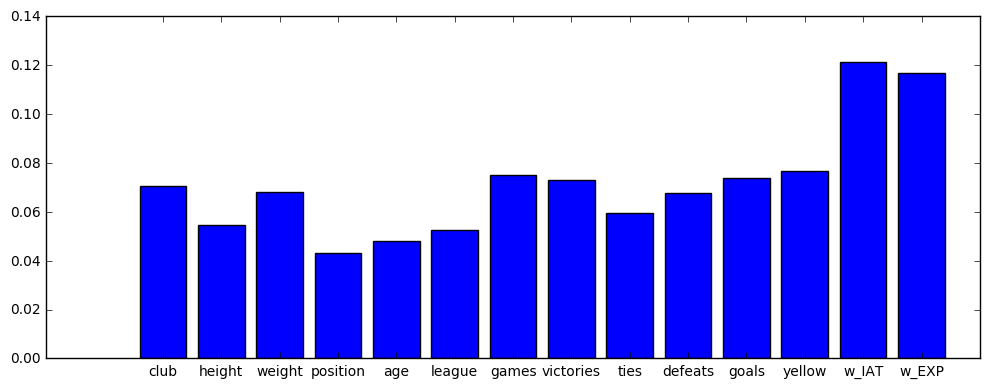

In [50]:
f_importance_2_drop = gs_cv_2_drop.best_estimator_.get_params()['rf'].feature_importances_


f_label = ['club', 'height', 'weight', 'position', 'age',
                'league','games','victories', 'ties', 
                'defeats', 'goals', 'yellow', 
                'w_IAT', 'w_EXP']
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,4))

plt.bar(range(len(f_importance_2_drop)), f_importance_2_drop, align="center")
plt.xticks(range(len(f_importance_2_drop)),f_label, color='black')

fig.tight_layout()
plt.show()



## 1.4 Conclusion
1. Our best model for classification reaches cv_score of 0.85078. In that case, we group data by player at first, then drop some unimportant features, then use gridsearchCV() function to find best parameter set as {'rfmax_depth': 25, 'rfmax_features': 'sqrt', 'rfn_estimators':17}.
2. For the overall features, two most important features for the best model 'weighted mean of IATscore' and 'weighted mean of Exp score', while two least important features are 'yellowReds' and 'redCards'.
3. Dropping some unimportant features will help us improve the cv_score a bit, also it change the distribution of feature_importance to be more evenly distributed.
5. Conducting grid search cross validation will help us lower the extent of overfitting.

# Task 2

Aggregate the referee information by player, and then produce two disjoint clusters for soccer players.

The following function `agg_player` produces a dataframe with unique players. Invariants of a player, such as heights, weights, club and league, are of the original value since they are the same for a player; while the variables such as number of yellow and red cards for each game are used to get weighted means with respect to games weight. 

In [3]:
def agg_player(data, weighted_cols, sum_cols):
    # map categorical variables to codes
    data['club'] = data['club'].astype('category').cat.codes
    data['leagueCountry'] = data['leagueCountry'].astype('category').cat.codes
    data['position'] = data['position'].astype('category').cat.codes
    data['group'] = data['playerShort'].astype('category').cat.codes
    # generate age feature
    data['age'] = 2016 - data['birthday'].str.rsplit('.', 1, True)[1].astype('int')
    
    # multiply weighted columns with their weights, `games` value
    for col in weighted_cols:
        data[col] = data[col] * data['games']

    # split data into two groups
    # group1 contains invariants, e.g. club, height of a player
    group1 = data.groupby('playerShort').agg('mean')[
        ['leagueCountry', 'club', 'height', 'weight', 'age', 'position']]
    # group2 contains variants for a player that need to be added, e.g. number of cards
    group2 = data.groupby('playerShort').agg('sum')[sum_cols]
    # concatenate two groups
    res = pd.concat([group1.ix[:, :-1], group2], axis=1)

    # produce weighted mean for desired weighted columns
    for col in weighted_cols:
        res[col] = res[col] / res['games']
    
    return res

In [4]:
x = agg_player(data, 
           ['meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'],
           ['games', 'victories', 'ties', 'defeats', 'goals', 
            'yellowCards', 'yellowReds', 'redCards', 
            'refNum', 'refCountry',
            'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'
           ])

First we want to use GridSearchCV to find the best clustering model with highest score, equally the highest absolute value of the score of KMeans model.

In [5]:
params = {
    'kmeans__max_iter': [500, 1000, 1500, 2000],
    'kmeans__init': ['random', 'k-means++'],
    'kmeans__algorithm': ['full', 'elkan'],
    'kmeans__n_init': [i for i in range(1, 11)]
}
pipe = Pipeline([
         ('replace', Imputer(strategy='median')),  # replace NaN value with median valuep
         ('kmeans', KMeans(n_clusters=2))  # classification
     ])
gs = GridSearchCV(pipe, params, n_jobs=-1,
            cv=ShuffleSplit(n_splits=20, test_size=0.2, train_size=0.8))
gs.fit(x)

GridSearchCV(cv=ShuffleSplit(n_splits=20, random_state=None, test_size=0.2, train_size=0.8),
       error_score='raise',
       estimator=Pipeline(steps=[('replace', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kmeans__algorithm': ['full', 'elkan'], 'kmeans__init': ['random', 'k-means++'], 'kmeans__max_iter': [500, 1000, 1500, 2000], 'kmeans__n_init': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Check the best score and best parameters for the best model

In [6]:
gs.best_score_, gs.best_params_

(-898115848695.5387,
 {'kmeans__algorithm': 'elkan',
  'kmeans__init': 'k-means++',
  'kmeans__max_iter': 2000,
  'kmeans__n_init': 7})

We can see the silhouette score for the best model, `KMeans(2, max_iter=1500, init='k-means++', algorithm='elkan', n_init=2)`

In [7]:
def get_silhouette_score(x, estimator):
    cls = estimator
    cls_labels = cls.fit_predict(x)
    score = silhouette_score(x, cls_labels)
    return score

We reach 0.48 for the best estimator

In [7]:
from sklearn.cluster import AgglomerativeClustering
tx = Imputer(strategy='median').fit_transform(x)
get_silhouette_score(tx, KMeans(2, max_iter=1500, init='random', algorithm='full', n_init=3))

0.48677590008849375

Next we will remove **the least important** features iteratively and see how the silhouette score changes

In [8]:
feature_importance = [
    0.06672991,  0.05214417,  0.05665237,  0.0411245 ,  0.04477985, 
    0.0578409 ,  0.06585295,  0.07985616,  0.05489152,  0.06987497,
    0.07734497,  0.06031401,  0.02388019,  0.02271411,  0.12232772,
    0.10367171
]
from scipy.stats import rankdata
ranks = rankdata(feature_importance)

In [9]:
silhouette_scores = []
feature_cols = [i for i in range(16)]
d = {i-1:j for i, j in zip(ranks, feature_cols)}  # construct a dictionary with importance rank and column index

# get score while removing least import features
for i in feature_cols:
    score = get_silhouette_score(tx[:, list(d.values())], KMeans(2, max_iter=1500, init='random', algorithm='full', n_init=3))
    silhouette_scores.append(score)
    del d[i]  # remove ith feature column

NameError: name 'tx' is not defined

In [ ]:
res = pd.DataFrame([[i,j] for i, j in enumerate(silhouette_scores)])
res.columns = ['feature length', 'silhouette score']
res

In [ ]:
res.plot.scatter('number of removed features', 'silhouette score') 

from the above chart we can see, after removing the 1st least important feature, the score imporoved a lot. After removing 7th least important feature, the score increased a little bit. The score stays almost the same for the rest removal.